# First Score Model

Paper: https://arxiv.org/abs/1907.05600

In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn


from torch.autograd import grad

Using torch 1.13.1


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_timesteps, embed_dim=4):
        super().__init__()

        # 'Attach' a time onto our input data
        self.embedding = nn.Embedding(num_timesteps, embed_dim)

        # Layer stack 
        self.layers = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 128),  
            nn.Sigmoid(),
            nn.Linear(128, output_dim)
        )

    def forward(self, X, t):
        
        # Apply embedding to 't'
        t_embedded = self.embedding(t.flatten())
        X_embedded = torch.cat([X, t_embedded], dim=1)  # Concatenate along dimension 1

        return self.layers(X_embedded)

In [4]:
class Diffuser:
    def __init__(self, num_timesteps, beta_range=(0.0001, 0.02), device='cuda'):
        self.device = device
        self.timesteps = num_timesteps

        self.betas = torch.linspace(beta_range[0], beta_range[1], num_timesteps, device=self.device)

        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar).to(self.device)
        self.sqrt_alpha_reciprocal = (1. / torch.sqrt(self.alphas)).to(self.device)
        self.sqrt_1minus_alpha_bar = torch.sqrt(1 - self.alpha_bar).to(self.device)

    def forwards_diffusion(self, x0, t):

        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0, device=self.device)

        # 2. Bias it to increase mean --> mean = sqrt(alpha_bar)*x0, var = (1-alpha_bar) * var(noise) * I
        mean = self.sqrt_alpha_bar[t] * x0

        # 3. Multiply to change standard deviation --> mean = 0 var = (1-alpha_bar) * var(noise) * I
        variance = self.sqrt_1minus_alpha_bar[t] * noise

        sample = mean + variance

        return sample.float()


In [5]:
def loss_function(model_score, X_noise, X, sigma):

    grad_log_q = X_noise - X / sigma**2
    loss = 1 / 2. * ((model_score - grad_log_q) ** 2).sum(dim=-1).mean(dim=0)
    
    return loss

In [6]:
class Sampler:
    def __init__(self, epsilon, timesteps, num_samples, device='cpu') -> None:
        self.device = device
        self.eps = torch.tensor(epsilon, device=self.device) 
        self.timesteps = timesteps
        self.samples = num_samples
    
    def sampling_loop(self, model, diffuser):

        # Sample x_T from the standard Gaussian distribution as a scalar tensor
        x_t = torch.randn(size=(self.samples, 2), device=self.device)
        
        with torch.no_grad():
            # Paper notation: for i in sigma_i
            for t_diff in range(diffuser.timesteps):
                
                # Extract the noise step size
                t_index = torch.ones(self.samples, 1, device=self.device, dtype=torch.long) * t_diff
                sigma_i = diffuser.sqrt_1minus_alpha_bar[t_diff]
                sigma_T = diffuser.sqrt_1minus_alpha_bar[-1]
                alpha_i = self.eps * torch.square(sigma_i/sigma_T)

                # Paper notation: for t in T
                for t_sample in range(self.timesteps):
                    
                    # Sample from standard gaussian
                    z = torch.randn_like(x_t, device=self.device)

                    # Langevin update step
                    x_t = x_t + ((alpha_i/2) * model(x_t, t_index)) + (torch.sqrt(alpha_i) * z)

        return x_t

In [7]:
def train_step(model, diffuser, X, optimiser, loss_fn):

    # Sample a time
    t = torch.randint(0, diffuser.timesteps, (X.shape[0],1), device = diffuser.device)

    # Perturb X
    X_bar = diffuser.forwards_diffusion(X, t) # Get noisy image at time t in the diffusion schedule

    # 1. Forward pass
    pred_score = model(X_bar, t)

    # 2. Calc loss
    loss = loss_fn(pred_score, X_bar, X, diffuser.sqrt_1minus_alpha_bar[t])

    # 3. Optimizer zero-grad
    optimiser.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Update -- gradient ascent
    optimiser.step() 

    return loss

  0%|          | 0/10000 [00:00<?, ?it/s]

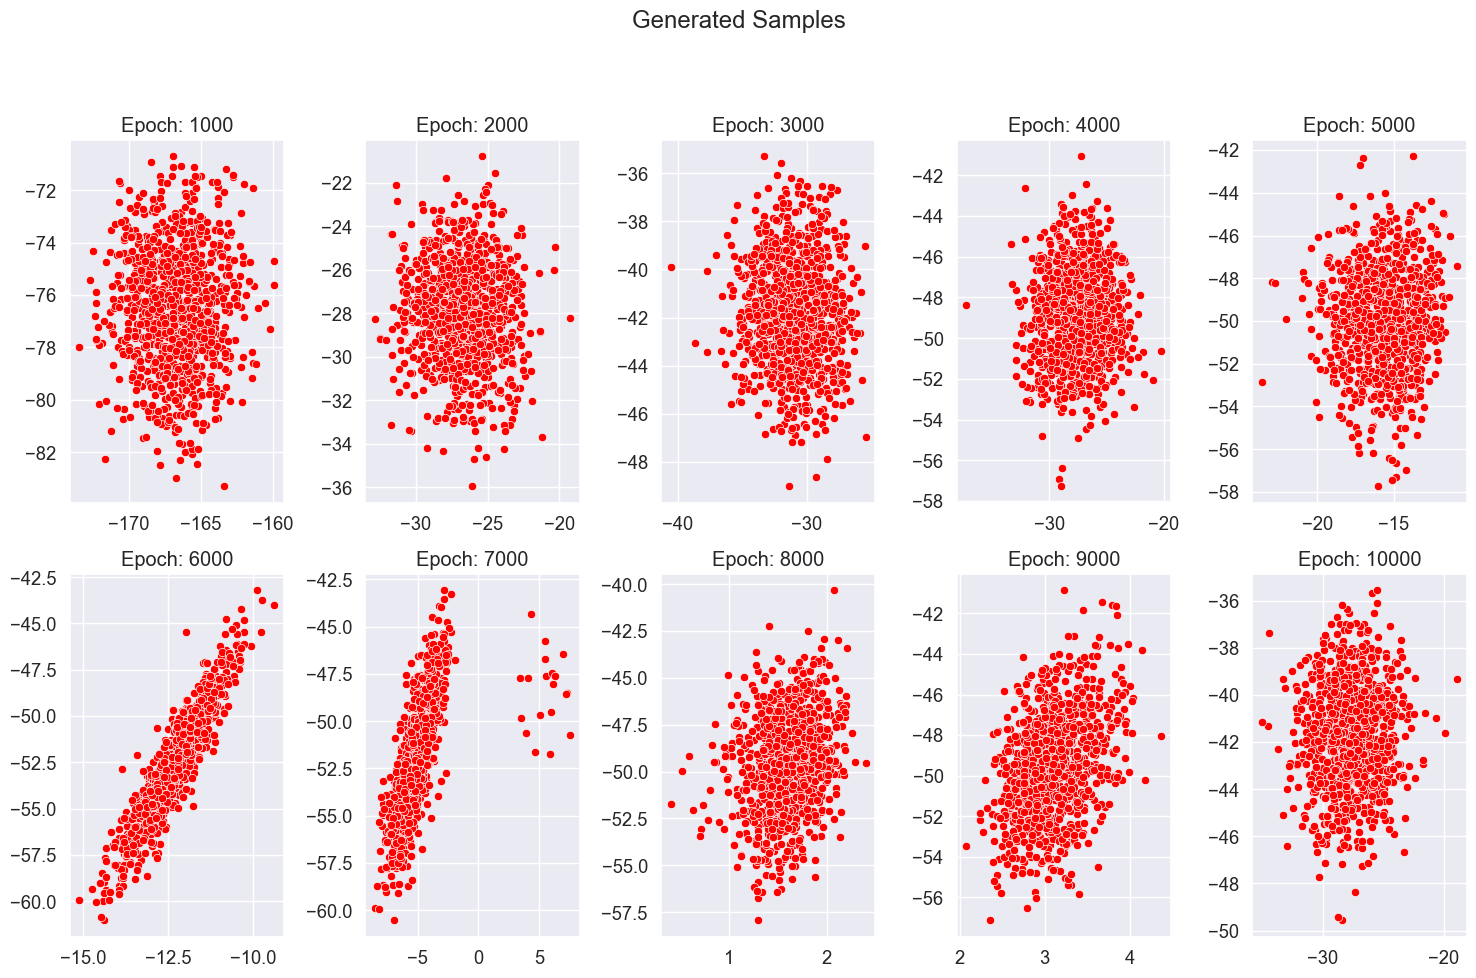

In [8]:
# Hyperparams
EPOCHS = 10000
TIMESTEPS = 100
SAMPLES = 1000
EPSILON = 0.01
LR = 0.01
BATCH_SIZE = 250

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the moons dataset
X, _ = make_moons(n_samples=SAMPLES, noise=0.05, random_state=42)
X = torch.tensor(X).float()

sampler = Sampler(epsilon=EPSILON, 
                  timesteps = TIMESTEPS//10, 
                  num_samples = SAMPLES, 
                  device = device)

net = ScoreNet(input_dim = X.shape[1], 
               output_dim = X.shape[1],
               num_timesteps=TIMESTEPS).to(device)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser(num_timesteps=TIMESTEPS, device=device)

optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = loss_function

# Determine the number of batches
num_batches = (len(X) - 1) // BATCH_SIZE + 1

# Calculate the number of rows and columns for subplots
sample_every = EPOCHS//10
num_plots = (EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(1, EPOCHS+1))

for epoch in tqdm_bar:
    avg_loss_epoch = 0

    for batch_idx in range(num_batches):

        # Collect batch
        start_index = batch_idx * BATCH_SIZE
        end_index = min((batch_idx + 1) * BATCH_SIZE, len(X))
        X_batch = X[start_index:end_index].to(device)

        loss= train_step(model = net, 
                            diffuser = D,
                            X = X_batch, 
                            optimiser = optimiser, 
                            loss_fn = loss_function)
        
        avg_loss_epoch += loss

    avg_loss_epoch /= num_batches
    tqdm_bar.set_description(f"Epoch {epoch}, Average Loss: {avg_loss_epoch:.4f}")
            
    if (epoch % sample_every == 0 or epoch == EPOCHS) and (epoch > 0):
                with torch.no_grad():
                        
                        # Draw samples from noisy dist using score net
                        x0 = sampler.sampling_loop(model=net, diffuser=D)
                        
                        plot_num = (epoch // sample_every) - 1
                        row = plot_num // num_cols
                        col = (plot_num % num_cols)

                        # Plot x0 on the specified subplot
                        sns.scatterplot(x=x0[:, 0].cpu().numpy(), y=x0[:, 1].cpu().numpy(),
                        color='red', marker='o', ax=axs[row, col])

                        axs[row, col].set_title(f'Epoch: {epoch}')
                
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()